In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
import sklearn.metrics as metrics
import kagglehub
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
import cv2 as cv
import random
import torch
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T, DatasetMapper
from detectron2.data import build_detection_train_loader
from detectron2.utils.visualizer import ColorMode


# Original dataset
#path = kagglehub.dataset_download("saurabhshahane/mnist-for-object-detection")
#im_path = "/Users/quino070/.cache/kagglehub/datasets/saurabhshahane/mnist-for-object-detection/versions/1/mnist_detection"
im_path = "/Users/quino070/LeafShapeAnalysis/mnist_detection"


In [2]:
def get_labels(set: str) -> pd.DataFrame:
    folder = f"{im_path}/{set}/labels/"
    dfs = []

    for name in sorted(os.listdir(folder)):
        df = pd.read_csv(folder + name)
        df["file_name"] = name.replace(".txt", "")
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

train_labels = get_labels("train")
test_labels = get_labels("test")

In [3]:
train_images_name = sorted(os.listdir(f"{im_path}/train/images"))
test_images_name = sorted(os.listdir(f"{im_path}/test/images"))

In [4]:
def get_detectron_dicts(tset,images_name, labels):
    dataset_dicts = []

    for idx, img_path in enumerate(images_name):
        record = {}
        # Access image and record dimensions
        filename = img_path
        image = cv.imread(f'{im_path}/{tset}/images/{filename}')
        height, width = image.shape[:2]

        record["file_name"] = im_path+"/"+tset+"/images/"+filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        # get annotation row for this image
        row = labels[labels["file_name"] == filename.replace(".png", "")].iloc[0]

        obj = {
            "bbox": [
                int(row["xmin"]), 
                int(row["ymin"]), 
                int(row["xmax"]), 
                int(row["ymax"])
            ],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": int(row["label"]),
            "iscrowd": 0,
        }

        record["annotations"] = [obj]
        dataset_dicts.append(record)

    return dataset_dicts

In [5]:
digit_train = get_detectron_dicts("train",train_images_name, train_labels)
digit_test = get_detectron_dicts("test",test_images_name, test_labels)

In [6]:
DatasetCatalog.register("digit_train", lambda: digit_train)

MetadataCatalog.get("digit_train").set(thing_classes=[str(i) for i in range(10)])

DatasetCatalog.register("digit_test", lambda: digit_test)

MetadataCatalog.get("digit_test").set(thing_classes=[str(i) for i in range(10)])

namespace(name='digit_test',
          thing_classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [7]:
def visualize_dataset(datasetname, tset, n_samples=10):

    dataset_dicts = DatasetCatalog.get(datasetname)
    metadata = MetadataCatalog.get(datasetname)

    for d in random.sample(dataset_dicts,n_samples):
        fn = d['file_name']
        print(fn)
        img = cv.imread(fn)
        visualizer = Visualizer(img[:, :, ::-1],
        metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
        plt.axis("off")
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.show()

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/2940_1.png


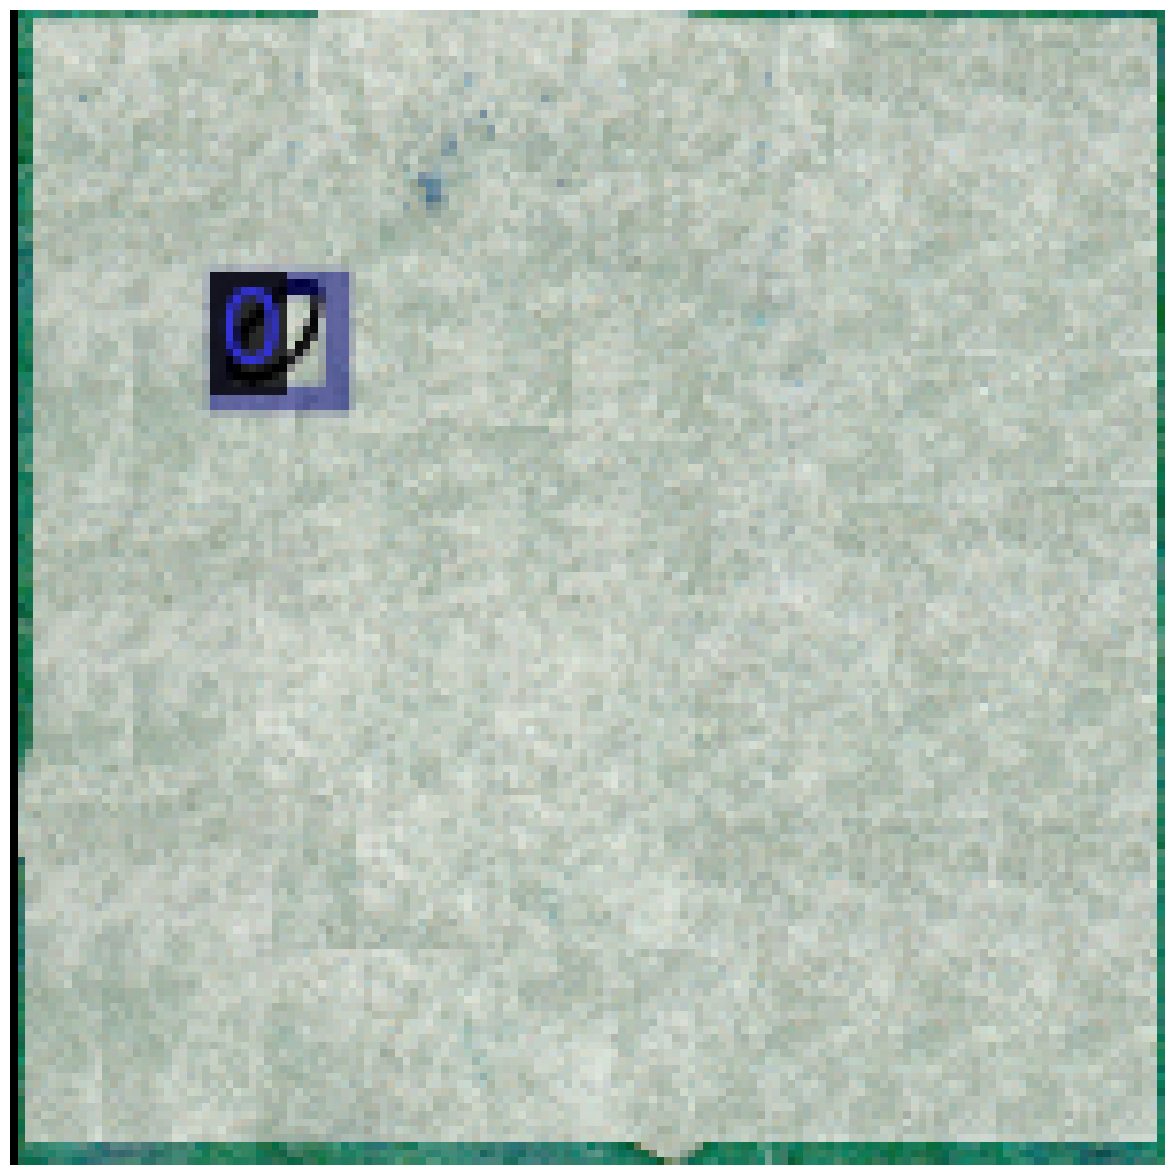

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/7104_2.png


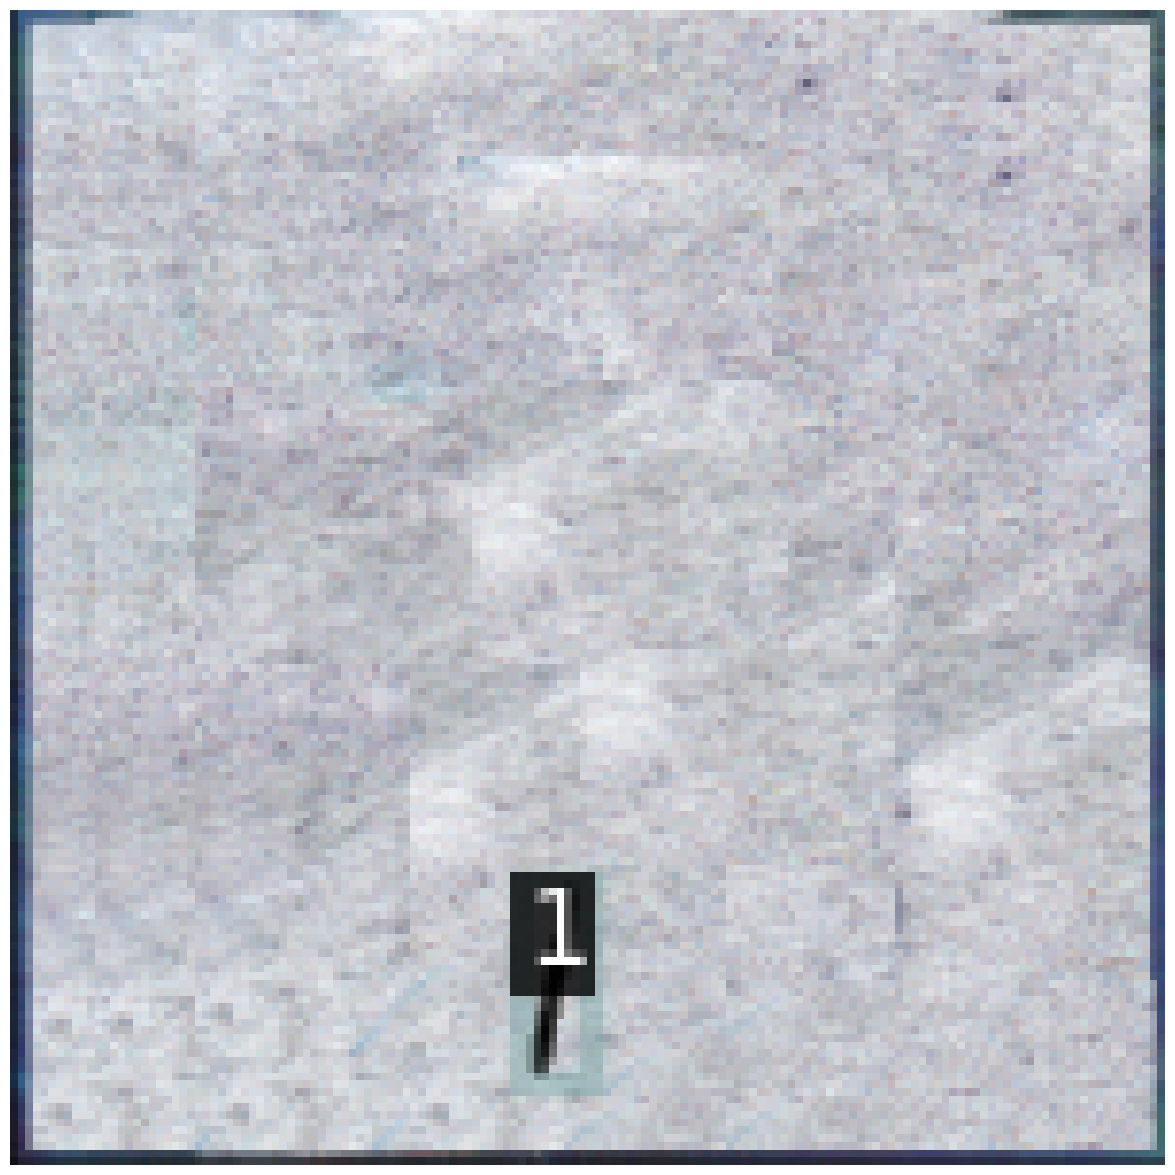

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/6186_2.png


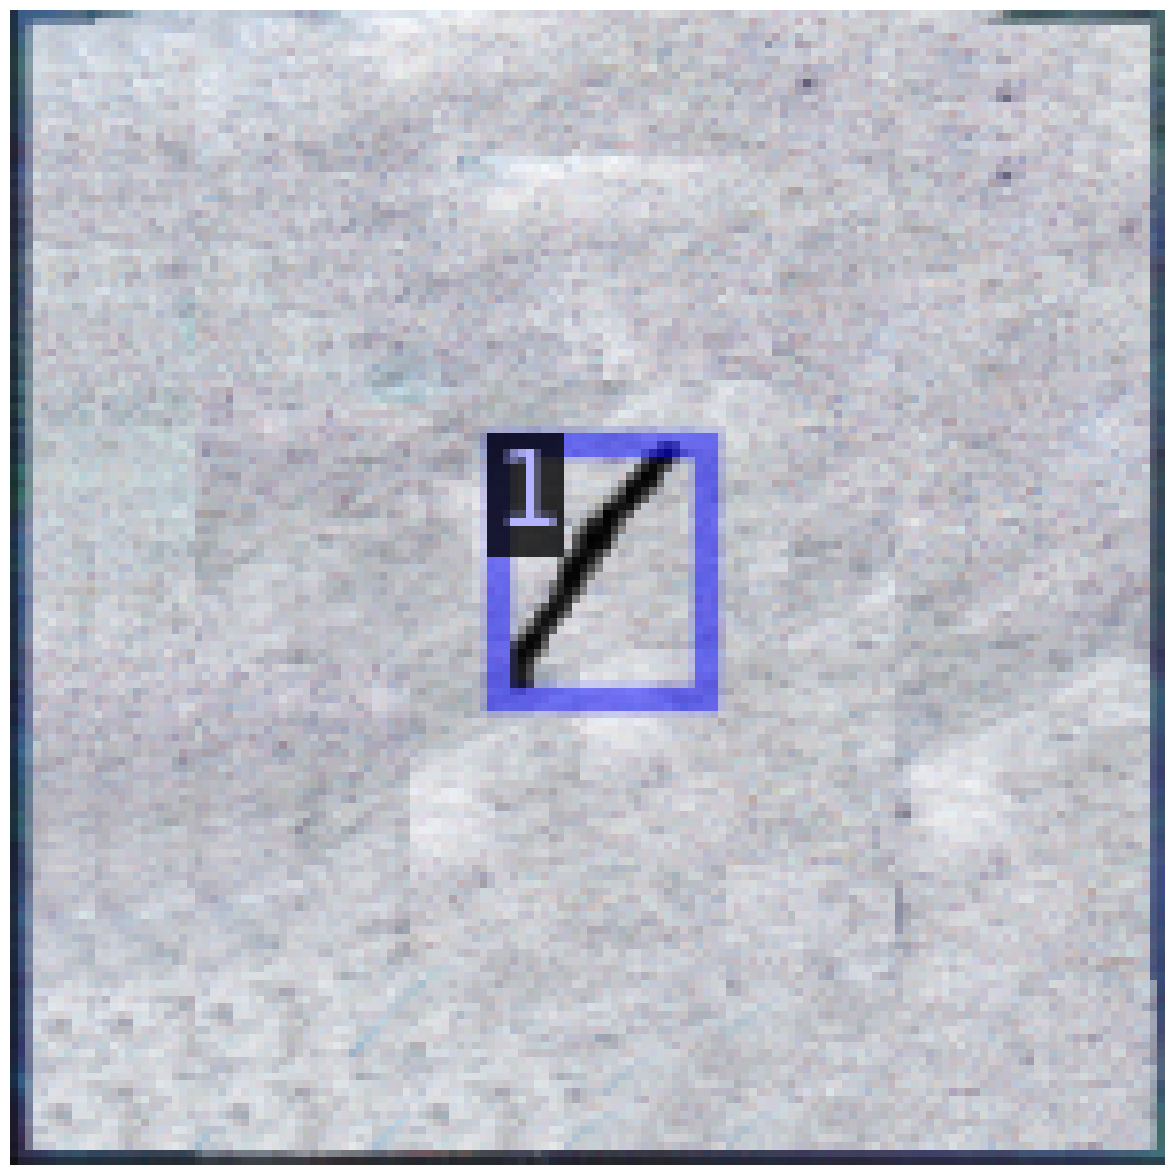

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/4488_2.png


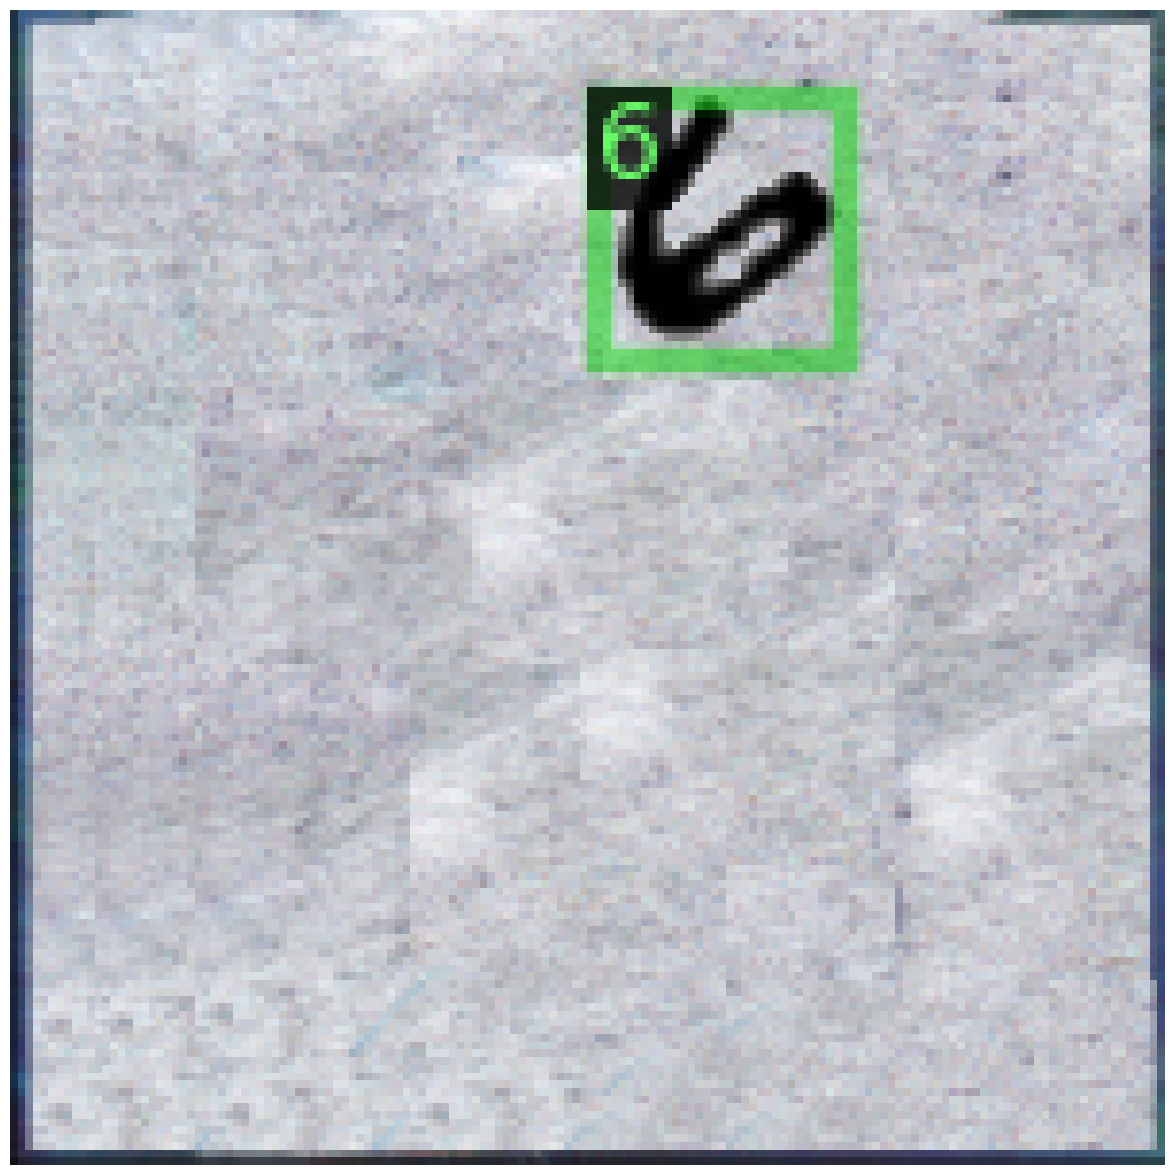

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/9591_2.png


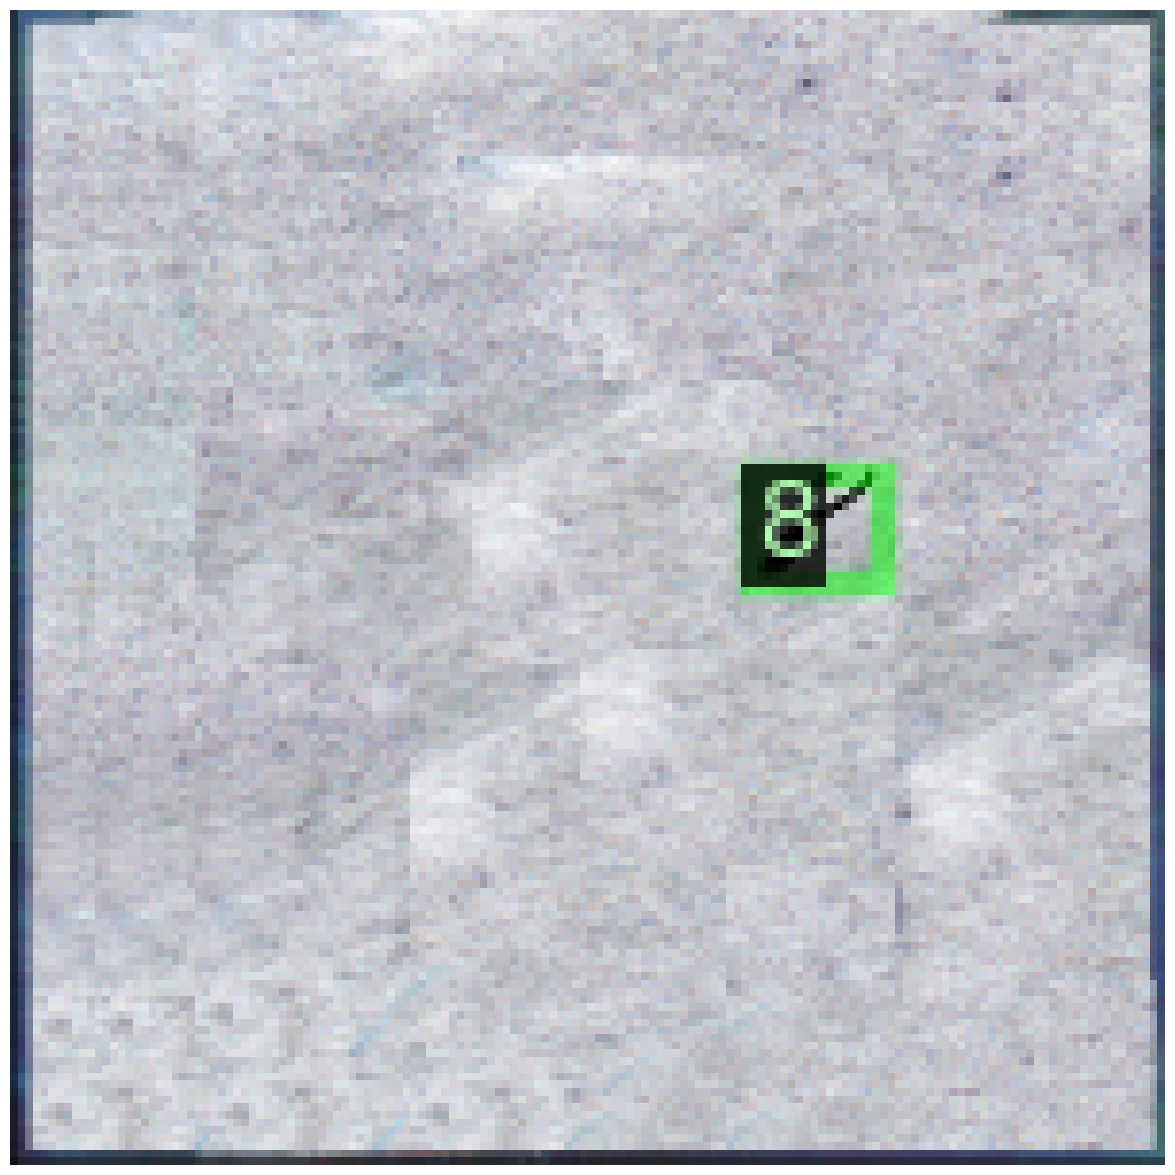

In [8]:
visualize_dataset("digit_train", "train", 5)

In [13]:
class CustomTrainer(DefaultTrainer):
    """
    A Trainer that overrides the default data loader to include custom augmentations,
    including random horizontal and vertical flips.
    """
    @classmethod
    def build_train_loader(cls, cfg):
        # Define your custom augmentations as a list of Augmentation objects
        augmentations = [
            #T.RandomBrightness(0.75, 1.3),  # Example: Random brightness adjustment
            #T.RandomContrast(0.75, 1.3),    # Example: Random contrast adjustment
            T.RandomRotation(angle=[-30, 30], expand=False), # Example: Random rotation
            # Augmentation for random horizontal flip (mirror on x-axis)
            #T.RandomFlip(prob=0.5, horizontal=True, vertical=False), 
            # Augmentation for random vertical flip (mirror on y-axis)
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True), 
            T.ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice'), # Default resize
        ]
        
        # Create a custom mapper with your augmentations
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)
        
        # Build and return the data loader
        return build_detection_train_loader(cfg, mapper=mapper)

In [14]:
# cfg = get_cfg()
# cfg.MODEL.DEVICE = "cpu"

# cfg.merge_from_file(
#     model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml")
# )

# # Datasets
# cfg.DATASETS.TRAIN = ("digit_train",)
# cfg.DATASETS.TEST = ("digit_test",)

# # Dataloader
# cfg.DATALOADER.NUM_WORKERS = 2

# # Weights
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
#     "COCO-Detection/retinanet_R_50_FPN_1x.yaml"
# )

# # Solver
# cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 1e-4
# cfg.SOLVER.MAX_ITER = 5000
# cfg.SOLVER.STEPS = []
# cfg.SOLVER.WARMUP_ITERS = 500

# # RetinaNet-specific
# cfg.MODEL.RETINANET.NUM_CLASSES = 10
# cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.25

# # Image size (important for your 300x300 data)
# cfg.INPUT.MIN_SIZE_TRAIN = (300,)
# cfg.INPUT.MAX_SIZE_TRAIN = 300
# cfg.INPUT.MIN_SIZE_TEST = 300
# cfg.INPUT.MAX_SIZE_TEST = 300

# # Output
# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# # -----------------------------
# # Train
# # -----------------------------
# trainer = CustomTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [15]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("digit_train",)
cfg.DATASETS.TEST = ("digit_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0002  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.BACKBONE.FREEZE_AT = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/17 14:57:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/17 14:57:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomRotation(angle=[-30, 30], expand=False), RandomFlip(prob=0.5, horizontal=False, vertical=True), ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/17 14:57:30 d2.data.build]: Removed 0 images with no usable annotations. 30000 images left.
[12/17 14:57:30 d2.data.build]: Using training sampler TrainingSampler
[12/17 14:57:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/17 14:57:30 d2.data.common]: Serializing 30000 elements to byte tensors and concatenating them all ...
[12/17 14:57:30 d2.data.common]: Serialized dataset takes 7.68 MiB
[12/17 14:57:30 d2.data.build]: Making batched data loader with batch_size=5
[12/17 14:57:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/mod

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[12/17 14:57:30 d2.engine.train_loop]: Starting training from iteration 0
[12/17 15:01:10 d2.utils.events]:  eta: 14:47:25  iter: 19  total_loss: 2.601  loss_cls: 2.278  loss_box_reg: 0.3002  loss_rpn_cls: 0.007634  loss_rpn_loc: 0.006867    time: 10.7987  last_time: 9.7800  data_time: 0.1378  last_data_time: 0.0167   lr: 3.9962e-06  
[12/17 15:04:59 d2.utils.events]:  eta: 15:19:19  iter: 39  total_loss: 2.436  loss_cls: 2.154  loss_box_reg: 0.288  loss_rpn_cls: 0.007305  loss_rpn_loc: 0.007565    time: 11.1504  last_time: 10.7280  data_time: 0.0203  last_data_time: 0.0150   lr: 7.9922e-06  
[12/17 15:08:45 d2.utils.events]:  eta: 15:18:57  iter: 59  total_loss: 2.091  loss_cls: 1.821  loss_box_reg: 0.2757  loss_rpn_cls: 0.01318  loss_rpn_loc: 0.006333    time: 11.2064  last_time: 11.0857  data_time: 0.0195  last_data_time: 0.0210   lr: 1.1988e-05  
[12/17 15:12:09 d2.utils.events]:  eta: 15:04:46  iter: 79  total_loss: 1.667  loss_cls: 1.366  loss_box_reg: 0.2597  loss_rpn_cls: 0.011

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

In [ ]:
#Loading in model for inference
# 2. Set the path to your saved model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # <-- your trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # threshold for predictions
cfg.MODEL.DEVICE = "cpu"  # or "cuda" if GPU is available

# 3. Create predictor
predictor = DefaultPredictor(cfg)

In [ ]:
from skimage import io
#test_im = io.imread("https://marketplace.canva.com/EAFq4CUhZFM/1/0/1600w/canva-numbers-1-to-100-square-flashcards-7nLIk20HbUo.jpg")

for im in random.sample(test_images_name,5):
    test_im = cv.imread(f"{im_path}/test/images/{im}")
    outputs = predictor(test_im)
    #v = Visualizer(test_im[:, :, ::-1],
    #                   scale=0.5,
    #                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    #    )
    #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out = cv.cvtColor(test_im, cv.COLOR_BGR2RGB)
    
    instances = outputs["instances"]

    if len(instances) == 0:
        pred_class = None  # or -1, or skip
    else:
        pred_class = int(instances.pred_classes[0])
    
    plt.figure()
    #plt.imshow(out.get_image()[:,:,::-1])
    plt.imshow(out)
    plt.title(f"Predicted:{pred_class}")
    plt.show()

In [ ]:
test = cv.imread("/Users/quino070/Desktop/tag_for_hist.png")
#test = io.imread("https://marketplace.canva.com/EAFq4CUhZFM/1/0/1600w/canva-numbers-1-to-100-square-flashcards-7nLIk20HbUo.jpg")

outputs = predictor(test)
v = Visualizer(test[:, :, ::-1],scale=0.5,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
instances = outputs["instances"]
pred = np.array(instances.pred_classes)
if len(instances) == 0:
    pred = None  # or -1, or skip
else:
    pred = np.array(instances.pred_classes)
    pred=int("".join(map(str, pred)))

plt.imshow(out.get_image()[:,:,::-1])
plt.title(f"Predicted:{pred}")
plt.show()

In [ ]:
test = cv.imread("/Users/quino070/Desktop/tag3.png")
outputs = predictor(test)
v = Visualizer(test[:, :, ::-1],scale=0.5,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
instances = outputs["instances"]
pred = np.array(instances.pred_classes)
if len(instances) == 0:
    pred = None  # or -1, or skip
else:
    pred = np.array(instances.pred_classes)
    pred=int("".join(map(str, pred)))

plt.imshow(out.get_image()[:,:,::-1])
plt.title(f"Predicted:{pred}")
plt.show()

In [ ]:
DatasetCatalog.remove("digit_train")
MetadataCatalog.remove("digit_train")
DatasetCatalog.remove("digit_test")
MetadataCatalog.remove("digit_test")